In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

import category_encoders as ce

plt.style.use('seaborn-colorblind')
%matplotlib inline

In [2]:
# Считываем только необходимые колонки (не все)
use_cols = ['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Survived']

# https://www.kaggle.com/c/titanic/data?select=train.csv
data = pd.read_csv('titanic.csv', usecols=use_cols)
print(data.shape)
data.head(8)

(891, 6)


,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250
3,1,1,female,35.0,1,53.1000
4,0,3,male,35.0,0,8.0500
5,0,3,male,NaN,0,8.4583
6,0,1,male,54.0,0,51.8625
7,0,3,male,2.0,3,21.0750


## Пропущенные значения

Проверка пропущенных значений

In [3]:
def check_missing(data, output_path=None):
    """Считаем количество пропусков и долю пропусков."""
    result = pd.concat([data.isnull().sum(), data.isnull().mean()], axis=1)
    result = result.rename(index=str, columns={0: 'total missing', 1: 'proportion'})
    if output_path:
        result.to_csv(f'{output_path}missing.csv')
        print(output_path, 'missing.csv')
    return result

In [4]:
check_missing(data=data)

,total missing,proportion
Survived,0,0.000000
Pclass,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Fare,0,0.000000


Удаление пропущенных значений

In [5]:
def drop_missing(data, axis=0):
    """Выкидываем строки, в которых есть NaN."""
    data_copy = data.copy(deep=True)
    data_copy = data_copy.dropna(axis=axis)
    return data_copy

In [6]:
data2 = drop_missing(data=data)
data2.shape

(714, 6)

Добавление переменной оценки пропущенных значений

In [7]:
def add_var_denote_NA(data, NA_col=None):
    """Добавляем колонку (0 или 1), которая обозначает есть NaN или нет в переданной колонке."""
    NA_col = NA_col or []
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum() > 0:
            data_copy[i+'_is_NA'] = np.where(data_copy[i].isnull(), 1, 0)
        else:
            warn("Нет пропущенных значений" % i)
    return data_copy

In [8]:
data3 = add_var_denote_NA(data=data, NA_col=['Age'])
print(data3.Age_is_NA.value_counts())
data3.head(8)

0    714
1    177
Name: Age_is_NA, dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Fare,Age_is_NA
0,0,3,male,22.0,1,7.2500,0
1,1,1,female,38.0,1,71.2833,0
2,1,3,female,26.0,0,7.9250,0
3,1,1,female,35.0,1,53.1000,0
4,0,3,male,35.0,0,8.0500,0
5,0,3,male,NaN,0,8.4583,1
6,0,1,male,54.0,0,51.8625,0
7,0,3,male,2.0,3,21.0750,0


Заполнение пропусков выборочным значением

In [9]:
def impute_NA_with_arbitrary(data, impute_value, NA_col=None):
    """Заполняем все пропуски в колонках ``NA_col`` значением ``impute_value``."""
    NA_col = NA_col or []
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum() > 0:
            data_copy[f"{i}_{impute_value}"] = data_copy[i].fillna(impute_value)
        else:
            warn("Нет пропущенных значений" % i)
    return data_copy

In [10]:
data4 = impute_NA_with_arbitrary(data=data, impute_value=-999, NA_col=['Age'])
data4.head(8)

,Survived,Pclass,Sex,Age,SibSp,Fare,Age_-999
0,0,3,male,22.0,1,7.2500,22.0
1,1,1,female,38.0,1,71.2833,38.0
2,1,3,female,26.0,0,7.9250,26.0
3,1,1,female,35.0,1,53.1000,35.0
4,0,3,male,35.0,0,8.0500,35.0
5,0,3,male,NaN,0,8.4583,-999.0
6,0,1,male,54.0,0,51.8625,54.0
7,0,3,male,2.0,3,21.0750,2.0


In [11]:
data4_ = data.copy(deep=True)
data4_.loc[:, 'Age'] = data['Age'].fillna(-999)
data4_.head(8)

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250
3,1,1,female,35.0,1,53.1000
4,0,3,male,35.0,0,8.0500
5,0,3,male,-999.0,0,8.4583
6,0,1,male,54.0,0,51.8625
7,0,3,male,2.0,3,21.0750


Заполнение пропущенных значений средним/медианой/модой

In [12]:
def impute_NA_with_avg(data,strategy='mean', NA_col=None):
    """Заполняет пропущенные значения в ``NA_col`` по стратегии ``strategy``."""
    NA_col = NA_col or []
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum() > 0:
            if strategy=='mean':
                data_copy[f"{i}_impute_mean"] = data_copy[i].fillna(data[i].mean())
            elif strategy=='median':
                data_copy[f'{i}_impute_median'] = data_copy[i].fillna(data[i].median())
            elif strategy=='mode':
                data_copy[f'{i}_impute_mode'] = data_copy[i].fillna(data[i].mode()[0])
        else:
            warn("Нет пропущенных значений" % i)
    return data_copy  

In [13]:
print(data.Age.median())
data5 = impute_NA_with_avg(data=data, strategy='median', NA_col=['Age'])
data5.head(8)

28.0


,Survived,Pclass,Sex,Age,SibSp,Fare,Age_impute_median
0,0,3,male,22.0,1,7.2500,22.0
1,1,1,female,38.0,1,71.2833,38.0
2,1,3,female,26.0,0,7.9250,26.0
3,1,1,female,35.0,1,53.1000,35.0
4,0,3,male,35.0,0,8.0500,35.0
5,0,3,male,NaN,0,8.4583,28.0
6,0,1,male,54.0,0,51.8625,54.0
7,0,3,male,2.0,3,21.0750,2.0


In [14]:
data5_ = data.copy(deep=True)
data5_.loc[:, 'Age'] = data['Age'].fillna(data['Age'].median())
data5_.head(8)

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250
3,1,1,female,35.0,1,53.1000
4,0,3,male,35.0,0,8.0500
5,0,3,male,28.0,0,8.4583
6,0,1,male,54.0,0,51.8625
7,0,3,male,2.0,3,21.0750


Заполнение пропусков значением из "хвоста" распределения

In [15]:
def impute_NA_with_end_of_distribution(data, NA_col=[]):
    """Заполняем пропуски значениями mean + 3*std (по правилу 3 сигм для нормального распределения)."""
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            data_copy[f'{i}_impute_end_of_distri'] = data_copy[i].fillna(data[i].mean() + 3*data[i].std())
        else:
            warn("Нет пропущенных значений" % i)
    return data_copy     

In [16]:
data6 = impute_NA_with_end_of_distribution(data=data,NA_col=['Age'])
data6.head(8)

,Survived,Pclass,Sex,Age,SibSp,Fare,Age_impute_end_of_distri
0,0,3,male,22.0,1,7.2500,22.00000
1,1,1,female,38.0,1,71.2833,38.00000
2,1,3,female,26.0,0,7.9250,26.00000
3,1,1,female,35.0,1,53.1000,35.00000
4,0,3,male,35.0,0,8.0500,35.00000
5,0,3,male,NaN,0,8.4583,73.27861
6,0,1,male,54.0,0,51.8625,54.00000
7,0,3,male,2.0,3,21.0750,2.00000


In [17]:
data6_ = data.copy(deep=True)
data6_.loc[:, 'Age'] = data['Age'].fillna(data['Age'].mean() + 3*data['Age'].std())
data6_.head(8)

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.00000,1,7.2500
1,1,1,female,38.00000,1,71.2833
2,1,3,female,26.00000,0,7.9250
3,1,1,female,35.00000,1,53.1000
4,0,3,male,35.00000,0,8.0500
5,0,3,male,73.27861,0,8.4583
6,0,1,male,54.00000,0,51.8625
7,0,3,male,2.00000,3,21.0750


Заполнение пропусков случайными значениями

In [18]:
def impute_NA_with_random(data, NA_col=None, random_state=0):
    """Заполняем пропуски случайными значениями из этой колонки."""
    NA_col = NA_col or []
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum() > 0:
            data_copy[f'{i}_random'] = data_copy[i]
            random_sample = data_copy[i].dropna().sample(data_copy[i].isnull().sum(), random_state=random_state)
            random_sample.index = data_copy[data_copy[i].isnull()].index
            data_copy.loc[data_copy[i].isnull(), f'{i}_random'] = random_sample
        else:
            warn("Нет пропущенных значений" % i)
    return data_copy 

In [19]:
data7 = impute_NA_with_random(data=data, NA_col=['Age'])
data7.head(8)

,Survived,Pclass,Sex,Age,SibSp,Fare,Age_random
0,0,3,male,22.0,1,7.2500,22.0
1,1,1,female,38.0,1,71.2833,38.0
2,1,3,female,26.0,0,7.9250,26.0
3,1,1,female,35.0,1,53.1000,35.0
4,0,3,male,35.0,0,8.0500,35.0
5,0,3,male,NaN,0,8.4583,28.0
6,0,1,male,54.0,0,51.8625,54.0
7,0,3,male,2.0,3,21.0750,2.0


## Выбросы

Детекция с помощью выборочных значений

In [20]:
def outlier_detect_arbitrary(data, col, upper_fence, lower_fence):
    """Определяем выбросы по переданным границам."""
    params = (upper_fence, lower_fence)
    tmp = pd.concat([data[col] > upper_fence, data[col] < lower_fence], axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:', outlier_index.value_counts()[1])
    print('Доля выбросов:', outlier_index.value_counts()[1]/len(outlier_index))    
    return outlier_index, params

In [21]:
index, params = outlier_detect_arbitrary(data=data, col='Fare', upper_fence=100, lower_fence=5)
print('Верхняя граница:', params[0], '\nНижняя граница:', params[1])

Количество выбросов в данных: 69
Доля выбросов: 0.07744107744107744
Верхняя граница: 100 
Нижняя граница: 5


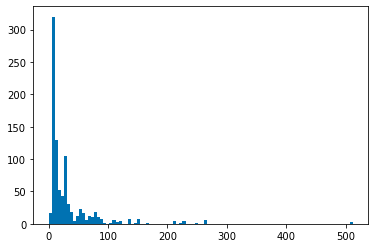

In [22]:
plt.hist(data['Fare'], bins=100);

In [23]:
data.loc[index, 'Fare'].sort_values()

597      0.0000
413      0.0000
822      0.0000
732      0.0000
302      0.0000
         ...   
88     263.0000
27     263.0000
737    512.3292
258    512.3292
679    512.3292
Name: Fare, Length: 69, dtype: float64

Интерквартильное расстояние

In [24]:
def outlier_detect_IQR(data, col, threshold=3):   
    """Определяем выбросы через интерквартильное расстояние."""
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    params = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col] > Upper_fence, data[col] < Lower_fence], axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:', outlier_index.value_counts()[1])
    print('Доля выбросов:', outlier_index.value_counts()[1] / len(outlier_index))
    return outlier_index, params

In [25]:
index, params = outlier_detect_IQR(data=data, col='Fare', threshold=5)
print('Верхняя граница:', params[0], '\nНижняя граница:', params[1])

Количество выбросов в данных: 31
Доля выбросов: 0.03479236812570146
Верхняя граница: 146.448 
Нижняя граница: -107.53760000000001


In [26]:
data.loc[index,'Fare'].sort_values()

31     146.5208
195    146.5208
305    151.5500
708    151.5500
297    151.5500
498    151.5500
609    153.4625
332    153.4625
268    153.4625
318    164.8667
856    164.8667
730    211.3375
779    211.3375
689    211.3375
377    211.5000
527    221.7792
700    227.5250
716    227.5250
557    227.5250
380    227.5250
299    247.5208
118    247.5208
311    262.3750
742    262.3750
341    263.0000
88     263.0000
438    263.0000
27     263.0000
679    512.3292
258    512.3292
737    512.3292
Name: Fare, dtype: float64

Среднее-среднеквадратичное отклонение

In [27]:
def outlier_detect_mean_std(data, col, threshold=3):
    """Определяем выбросы по правилу 3 сигм (из нормального распределения)."""
    Upper_fence = data[col].mean() + threshold * data[col].std()
    Lower_fence = data[col].mean() - threshold * data[col].std()   
    params = (Upper_fence, Lower_fence)   
    tmp = pd.concat([data[col] > Upper_fence, data[col] < Lower_fence], axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:', outlier_index.value_counts()[1])
    print('Доля выбросов:', outlier_index.value_counts()[1] / len(outlier_index))
    return outlier_index, params

In [28]:
index, params = outlier_detect_mean_std(data=data, col='Fare', threshold=3)
print('Верхняя граница:', params[0], '\nНижняя граница:', params[1])

Количество выбросов в данных: 20
Доля выбросов: 0.02244668911335578
Верхняя граница: 181.2844937601173 
Нижняя граница: -116.87607782296811


In [29]:
data.loc[index,'Fare'].sort_values()

779    211.3375
730    211.3375
689    211.3375
377    211.5000
527    221.7792
716    227.5250
700    227.5250
380    227.5250
557    227.5250
118    247.5208
299    247.5208
311    262.3750
742    262.3750
27     263.0000
341    263.0000
88     263.0000
438    263.0000
258    512.3292
737    512.3292
679    512.3292
Name: Fare, dtype: float64

Медианы абсолютного отклонения (MAD) 

In [30]:
def outlier_detect_MAD(data, col, threshold=3.5):
    """Определяем выбросы через MAD."""
    median = data[col].median()
    median_absolute_deviation = np.median([np.abs(y - median) for y in data[col]])
    modified_z_scores = pd.Series([0.6745 * (y - median) / median_absolute_deviation for y in data[col]])
    outlier_index = np.abs(modified_z_scores) > threshold
    print('Количество выбросов в данных:', outlier_index.value_counts()[1])
    print('Доля выбросов:', outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index

In [31]:
index = outlier_detect_MAD(data=data, col='Fare', threshold=3.5)

Количество выбросов в данных: 160
Доля выбросов: 0.17957351290684623


Замена выброса выборочным значением

In [32]:
def impute_outlier_with_arbitrary(data, outlier_index, value, col=None):
    """Заменяем выбросы значением ``value``."""
    col = col or []
    data_copy = data.copy(deep=True)
    for i in col:
        data_copy.loc[outlier_index,i] = value
    return data_copy

In [33]:
data2 = impute_outlier_with_arbitrary(data=data, outlier_index=index, value=-999, col=['Fare'])
data2[25:35]

,Survived,Pclass,Sex,Age,SibSp,Fare
25,1,3,female,38.0,1,31.3875
26,0,3,male,NaN,0,7.2250
27,0,1,male,19.0,3,-999.0000
28,1,3,female,NaN,0,7.8792
29,0,3,male,NaN,0,7.8958
30,0,1,male,40.0,0,27.7208
31,1,1,female,NaN,1,-999.0000
32,1,3,female,NaN,0,7.7500
33,0,2,male,66.0,0,10.5000
34,0,1,male,28.0,1,-999.0000


Виндзоризация

{92, 19, 101, 58, 1053, 91, 26, 78, 10, 13, −40, 101, 86, 85, 15, 89, 89, 28, −5, 41}  

{92, 19, 101, 58, 101, 91, 26, 78, 10, 13, −5, 101, 86, 85, 15, 89, 89, 28, −5, 41} 

In [34]:
def windsorization(data, col, params, strategy='both'):
    """Заменяем все значения большие params[1] значением params[1], а значения меньше params[0] значением params[0].
    При ``strategy = both`` - заменяем снизу и сверху,
        ``strategy = top`` - заменяем только сверху,
        ``strategy = bottom`` - заменяем только снизу."""
    data_copy = data.copy(deep=True)  
    if strategy == 'both':
        data_copy.loc[data_copy[col] > params[0], col] = params[0]
        data_copy.loc[data_copy[col] < params[1], col] = params[1]
    elif strategy == 'top':
        data_copy.loc[data_copy[col] > params[0], col] = params[0]
    elif strategy == 'bottom':
        data_copy.loc[data_copy[col] < params[1], col] = params[1]  
    return data_copy

In [35]:
data3 = windsorization(data=data, col='Fare', params=params, strategy='both')
data3[25:35]

,Survived,Pclass,Sex,Age,SibSp,Fare
25,1,3,female,38.0,1,31.387500
26,0,3,male,NaN,0,7.225000
27,0,1,male,19.0,3,181.284494
28,1,3,female,NaN,0,7.879200
29,0,3,male,NaN,0,7.895800
30,0,1,male,40.0,0,27.720800
31,1,1,female,NaN,1,146.520800
32,1,3,female,NaN,0,7.750000
33,0,2,male,66.0,0,10.500000
34,0,1,male,28.0,1,82.170800


In [36]:
data3_ = data.copy(deep=True)
data3_.loc[:, 'Fare'] = data3['Fare'].clip(params[0], params[1])
data3_[25:35]

,Survived,Pclass,Sex,Age,SibSp,Fare
25,1,3,female,38.0,1,31.387500
26,0,3,male,NaN,0,7.225000
27,0,1,male,19.0,3,181.284494
28,1,3,female,NaN,0,7.879200
29,0,3,male,NaN,0,7.895800
30,0,1,male,40.0,0,27.720800
31,1,1,female,NaN,1,146.520800
32,1,3,female,NaN,0,7.750000
33,0,2,male,66.0,0,10.500000
34,0,1,male,28.0,1,82.170800


Удаление выбросов

In [37]:
def drop_outlier(data, outlier_index):
    """Выкидываем выбросы."""
    data_copy = data[~outlier_index]
    return data_copy

In [38]:
data4 = drop_outlier(data=data, outlier_index=index)
print(data4.Fare.max())
print(data4.Fare.min())

50.0
0.0


Замена выбросов средним/медианой/модой

In [39]:
def impute_outlier_with_avg(data, col, outlier_index, strategy='mean'):
    """Заменяем все значения выбросов по переданной стратегии."""
    data_copy = data.copy(deep=True)
    if strategy=='mean':
        data_copy.loc[outlier_index, col] = data_copy[col].mean()
    elif strategy=='median':
        data_copy.loc[outlier_index, col] = data_copy[col].median()
    elif strategy=='mode':
        data_copy.loc[outlier_index, col] = data_copy[col].mode()[0]           
    return data_copy

In [40]:
data5 = impute_outlier_with_avg(data=data, col='Fare', outlier_index=index, strategy='mean')
data5[25:35]

,Survived,Pclass,Sex,Age,SibSp,Fare
25,1,3,female,38.0,1,31.387500
26,0,3,male,NaN,0,7.225000
27,0,1,male,19.0,3,32.204208
28,1,3,female,NaN,0,7.879200
29,0,3,male,NaN,0,7.895800
30,0,1,male,40.0,0,27.720800
31,1,1,female,NaN,1,32.204208
32,1,3,female,NaN,0,7.750000
33,0,2,male,66.0,0,10.500000
34,0,1,male,28.0,1,32.204208


# Local Outlier Factor

* Идея: давайте сравнивать плотность объектов с плотностями их $k$ ближайших соседей

* Шаги:

&emsp;&emsp;&emsp; 1) Reachability distance

$$ReachDist(a,b) = \max \big\{ KDistance(b),\; Dist(a,b) \big\}$$

&emsp;&emsp;&emsp; 2) Local reachability density (как далеко мы должны пройти от нашей точки, чтобы достичь следующей точки или группы точек)

$$lrd(a) = \frac{1}{\big( \sum\limits_{b\in N_k(a)} ReachDist(a,b) \;\big/\; k \big)}$$

&emsp;&emsp;&emsp; 3) Сравнивам с соседями:

$$LOF_k(a) = \frac{1}{|N_k(a)|}\sum\limits_{b\in N_k(a)}\frac{lrd(b)}{lrd(a)}$$

* Вывод:
  - $LOF ≈ 1$ $\implies$ no outlier
  - $LOF ≫ 1$ $\implies$ outlier

Useful links:

- https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf

- https://towardsdatascience.com/local-outlier-factor-for-anomaly-detection-cc0c770d2ebe

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/59/LOF.svg/1200px-LOF.svg.png" alt="LOF.svg">

##  Шкалирование данных

Обучение 2 параметров на данных train-выборки, чтобы применять их на test-выборке.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data, data.Survived, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((712, 6), (179, 6))

In [42]:
data

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250
3,1,1,female,35.0,1,53.1000
4,0,3,male,35.0,0,8.0500
...,...,...,...,...,...,...
886,0,2,male,27.0,0,13.0000
887,1,1,female,19.0,0,30.0000
888,0,3,female,NaN,1,23.4500
889,1,1,male,26.0,0,30.0000


In [43]:
X_train

,Survived,Pclass,Sex,Age,SibSp,Fare
140,0,3,female,NaN,0,15.2458
439,0,2,male,31.0,0,10.5000
817,0,2,male,31.0,1,37.0042
378,0,3,male,20.0,0,4.0125
491,0,3,male,21.0,0,7.2500
...,...,...,...,...,...,...
835,1,1,female,39.0,1,83.1583
192,1,3,female,19.0,1,7.8542
629,0,3,male,NaN,0,7.7333
559,1,3,female,36.0,1,17.4000


In [80]:
y_train

338    1.0
427    1.0
406    1.0
96     1.0
490    1.0
      ... 
277    0.0
9      0.0
359    1.0
192    1.0
559    1.0
Name: target, Length: 455, dtype: float64

Нормализация данных
$$z = \frac{x - \mu}{\sigma}$$

In [44]:
ss = StandardScaler().fit(X_train[['Fare']])
X_train_copy = X_train.copy(deep=True)
X_train_copy['Fare_zscore'] = ss.transform(X_train_copy[['Fare']])
print(X_train_copy.head(6))

     Survived  Pclass     Sex   Age  SibSp     Fare  Fare_zscore
140         0       3  female   NaN      0  15.2458    -0.331679
439         0       2    male  31.0      0  10.5000    -0.426405
817         0       2    male  31.0      1  37.0042     0.102620
378         0       3    male  20.0      0   4.0125    -0.555896
491         0       3    male  21.0      0   7.2500    -0.491276
331         0       1    male  45.5      0  28.5000    -0.067125


In [45]:
print(X_train_copy['Fare_zscore'].mean())
print(X_train_copy['Fare_zscore'].std())

1.3776433177757386e-16
1.0007029877845377


Мин-Макс шкалирование
$$z = \frac{x-min}{max-min}$$

In [46]:
mms = MinMaxScaler().fit(X_train[['Fare']])
X_train_copy = X_train.copy(deep=True)
X_train_copy['Fare_minmax'] = mms.transform(X_train_copy[['Fare']])
print(X_train_copy.head(6))

     Survived  Pclass     Sex   Age  SibSp     Fare  Fare_minmax
140         0       3  female   NaN      0  15.2458     0.029758
439         0       2    male  31.0      0  10.5000     0.020495
817         0       2    male  31.0      1  37.0042     0.072227
378         0       3    male  20.0      0   4.0125     0.007832
491         0       3    male  21.0      0   7.2500     0.014151
331         0       1    male  45.5      0  28.5000     0.055628


In [47]:
print(X_train_copy['Fare_minmax'].max())
print(X_train_copy['Fare_minmax'].min())

1.0
0.0


Робустное шкалирование
$$z = \frac{x-Q_1}{Q_3-Q_1}$$

In [48]:
rs = RobustScaler().fit(X_train[['Fare']])
X_train_copy = X_train.copy(deep=True)
X_train_copy['Fare_robust'] = rs.transform(X_train_copy[['Fare']])
print(X_train_copy.head(6))

     Survived  Pclass     Sex   Age  SibSp     Fare  Fare_robust
140         0       3  female   NaN      0  15.2458     0.033803
439         0       2    male  31.0      0  10.5000    -0.169380
817         0       2    male  31.0      1  37.0042     0.965349
378         0       3    male  20.0      0   4.0125    -0.447130
491         0       3    male  21.0      0   7.2500    -0.308522
331         0       1    male  45.5      0  28.5000     0.601257


In [49]:
print(X_train_copy['Fare_robust'].mean())
print(X_train_copy['Fare_robust'].std())

0.7452359587602414
2.1464514119217055


## Энкодинг переменных 

One-Hot encoding

In [50]:
data1 = pd.get_dummies(data)
data1.head()

,Survived,Pclass,Age,SibSp,Fare,Sex_female,Sex_male
0,0,3,22.0,1,7.2500,0,1
1,1,1,38.0,1,71.2833,1,0
2,1,3,26.0,0,7.9250,1,0
3,1,1,35.0,1,53.1000,1,0
4,0,3,35.0,0,8.0500,0,1


In [51]:
data1 = pd.get_dummies(data, drop_first=True)
data1.head()

,Survived,Pclass,Age,SibSp,Fare,Sex_male
0,0,3,22.0,1,7.2500,1
1,1,1,38.0,1,71.2833,0
2,1,3,26.0,0,7.9250,0
3,1,1,35.0,1,53.1000,0
4,0,3,35.0,0,8.0500,1


Энкодинг значением

In [52]:
data

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250
3,1,1,female,35.0,1,53.1000
4,0,3,male,35.0,0,8.0500
...,...,...,...,...,...,...
886,0,2,male,27.0,0,13.0000
887,1,1,female,19.0,0,30.0000
888,0,3,female,NaN,1,23.4500
889,1,1,male,26.0,0,30.0000


In [55]:
ord_enc = ce.OrdinalEncoder(cols=['Sex']).fit(X_train, y_train)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [56]:
data4 = ord_enc.transform(data)
print(data4.head(5))

   Survived  Pclass  Sex   Age  SibSp     Fare
0         0       3    2  22.0      1   7.2500
1         1       1    1  38.0      1  71.2833
2         1       3    1  26.0      0   7.9250
3         1       1    1  35.0      1  53.1000
4         0       3    2  35.0      0   8.0500


Таргет энкодинг

Использует значение таргета, так что может привести к переобучению.

$$s = \frac{1}{1+exp(-\frac{n-mdl}{a})};\quad \hat{x}^k = prior * (1-s) + s * \frac{n^{+}}{n}$$
- mdl means 'min data in leaf'
- a means 'smooth parameter, power of regularization'

In [57]:
target_enc = ce.TargetEncoder(cols=['Sex']).fit(X_train, y_train)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [58]:
data2 = target_enc.transform(data)
data2.head()

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,0.191398,22.0,1,7.2500
1,1,1,0.744939,38.0,1,71.2833
2,1,3,0.744939,26.0,0,7.9250
3,1,1,0.744939,35.0,1,53.1000
4,0,3,0.191398,35.0,0,8.0500


Catboost энкодинг

Использует значение таргета, так что может привести к переобучению.

In [59]:
catboost_enc = ce.CatBoostEncoder(cols=['Sex']).fit(X_train, y_train)
data3 = catboost_enc.transform(data)
data3.head()

/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,0.191810,22.0,1,7.2500
1,1,1,0.743482,38.0,1,71.2833
2,1,3,0.743482,26.0,0,7.9250
3,1,1,0.743482,35.0,1,53.1000
4,0,3,0.191810,35.0,0,8.0500


## Feature Selection

In [60]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
data = pd.DataFrame(np.c_[data['data'], data['target']], columns= np.append(data['feature_names'], ['target']))

In [61]:
data.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['target'], axis=1), 
                                                    data.target, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((455, 30), (114, 30))

Константные значения

In [63]:
def constant_feature_detect(data, threshold=0.98):  
    """Проверяем, что доля самой популярной значением фичи больше ``threshold``."""
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = data_copy[feature].value_counts(normalize=True).max()
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature), 'константные переменные')    
    return quasi_constant_feature

In [64]:
quasi_constant_feature = constant_feature_detect(data=X_train, threshold=0.9)

0 константные переменные


In [65]:
X_train['dummy'] = np.floor(X_train['worst smoothness'] * 10)
X_train.dummy.value_counts(normalize=True)

1.0    0.923077
0.0    0.068132
2.0    0.008791
Name: dummy, dtype: float64

In [66]:
quasi_constant_feature = constant_feature_detect(data=X_train, threshold=0.9)
quasi_constant_feature

1 константные переменные


['dummy']

In [67]:
X_train.drop(labels=quasi_constant_feature, axis=1, inplace=True)
print(X_train.shape)

(455, 30)


Корреляционная фильтрация

In [68]:
def corr_feature_detect(data, threshold=0.8):
    """Находим пару фичей, корреляция которых более ``threshold``."""
    
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() 
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] 
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]
    
            correlated_groups.append(correlated_block)
    return pd.concat(correlated_groups, sort=False)

In [69]:
corr_feature_detect(data=X_train, threshold=0.9)

,feature1,feature2,corr
0,mean perimeter,mean radius,0.998185
6,mean perimeter,mean area,0.986692
14,mean perimeter,worst perimeter,0.970507
19,mean perimeter,worst radius,0.969520
33,mean perimeter,worst area,0.941920
12,perimeter error,radius error,0.978323
30,perimeter error,area error,0.944995
36,mean concavity,mean concave points,0.914627
38,mean texture,worst texture,0.908182
40,worst concave points,mean concave points,0.906312


Взаимная информация

In [70]:
def mutual_info(X, y, select_k=10):
    """Находим колонки, у которых взаимная информация с таргетом максимальна. Отбираем ``select_k`` колонок."""

    if select_k >= 1:
        sel_ = SelectKBest(mutual_info_classif, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
        
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(mutual_info_classif, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
        
    else:
        raise ValueError("select_k должно быть положительным значением")
    
    return col

In [71]:
mi = mutual_info(X=X_train ,y=y_train, select_k=3)
print(mi)

Index(['mean concave points', 'worst perimeter', 'worst area'], dtype='object')


In [72]:
mi = mutual_info(X=X_train, y=y_train, select_k=0.2)
print(mi)

Index(['mean perimeter', 'mean concave points', 'worst radius',
       'worst perimeter', 'worst area', 'worst concave points'],
      dtype='object')


Хи-квадрат тест

In [73]:
def chi_square_test(X,y,select_k=10):
    """Находим колонки, у которых тест хи-квадрат с таргетом максимальна. Отбираем ``select_k`` колонок."""

    if select_k >= 1:
        sel_ = SelectKBest(chi2, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(chi2, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
    else:
        raise ValueError("select_k должно быть положительным значением")  
    
    return col

In [74]:
chi = chi_square_test(X=X_train,y=y_train,select_k=3)
print(chi)

Index(['mean area', 'area error', 'worst area'], dtype='object')


In [75]:
chi = chi_square_test(X=X_train,y=y_train,select_k=0.2)
print(chi)

Index(['mean perimeter', 'mean area', 'area error', 'worst radius',
       'worst perimeter', 'worst area'],
      dtype='object')


Одномерный ROC-AUC или MSE анализ

In [76]:
def univariate_roc_auc(X_train, y_train, X_test, y_test, threshold):

    roc_values = []
    for feature in X_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    roc_values = pd.Series(roc_values)
    roc_values.index = X_train.columns
    keep_col = roc_values[roc_values > threshold]
    return keep_col

In [77]:
uni_roc_auc = univariate_roc_auc(X_train, y_train, X_test, y_test, threshold=0.8)
print(uni_roc_auc.sort_values(ascending=False))

worst perimeter         0.917275
worst area              0.895840
worst radius            0.893458
worst concave points    0.863131
mean concavity          0.856939
mean radius             0.849000
mean area               0.839314
worst concavity         0.831375
mean perimeter          0.829628
mean concave points     0.826453
area error              0.812321
dtype: float64


In [78]:
def univariate_mse(X_train,y_train,X_test,y_test,threshold):

    mse_values = []
    for feature in X_train.columns:
        clf = DecisionTreeRegressor()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict(X_test[feature].to_frame())
        mse_values.append(mean_squared_error(y_test, y_scored))
    mse_values = pd.Series(mse_values)
    mse_values.index = X_train.columns
    keep_col = mse_values[mse_values > threshold]
    return keep_col   

In [79]:
uni_mse = univariate_mse(X_train, y_train, X_test, y_test, threshold=0.4)
print(uni_mse.sort_values(ascending=False))

mean fractal dimension     0.491228
symmetry error             0.480750
fractal dimension error    0.456140
smoothness error           0.449561
texture error              0.412281
worst smoothness           0.403265
dtype: float64
